### Faster-RCNN 总结域代码实现

* 1.Faster-RCNN 整体架构

* 2.Faster-RCNN 网络结构

* 3.整个模型的流程
    * 1.对整张图片进行cnn操作，得到feature map
    * 2.将feature map输入RPN网络，得到候选框坐标信息
    * 3.通过候选框坐标信息在feature map上提取特征，输入后续的cnn网络，得到特征信息
    * 4.通过ROI poolig得到固定大小的特征图，然后输入分类和回归分支，进行分类和回归

### 1.Faster-RCNN 整体架构

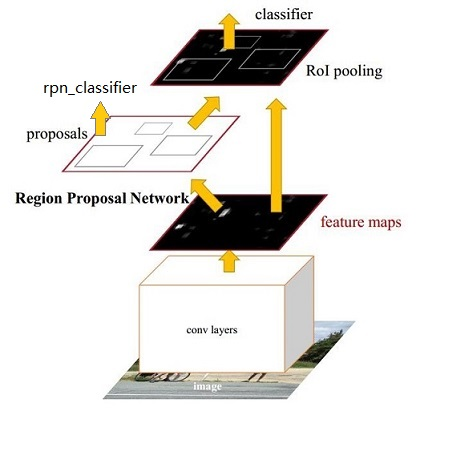

##### Faster-RCNN 由4个模块构成： 
    * 特征提取层
    * RPN(Region proposal Networks 区域提取网络)用于过滤没有目标的区域
    * Poi Pooling  主要目的是输出同尺寸大小向量
    * Classifier  用于分类
    
##### 特征提取层
使用 13层卷积 + 13层激活层 + 4层池化层 提取图像特征 用于后续RPN层和全连接分类层。 最后特征提取后的大小是关键，后面会讲到

##### RPN(Region proposal Networks 区域提取网络)
RPN的主要作用是去除一些没有目标对象的Anchor Box。RPN有两个分支: anchor box的二分类，anchor box 的回归。anchor box的二分类 用来识别anchor box 是否有目标。anchor box 的回归 用来修正 anchor box,形成较精准的proposal

##### Roi Pooling 
这一层，利用RPN生成的proposal和特征提取层得到的特征，得到固定大小的proposal feature map，用于后续全连接进行目标识别和定位

##### Classifier
 使用Roi Pooling 得到固定大小的特征，进行多分类。同时，利用L1 Loss 完成bounding box regression回归操作获得物体的精确位置

### 2.Faster-RCNN 网络结构

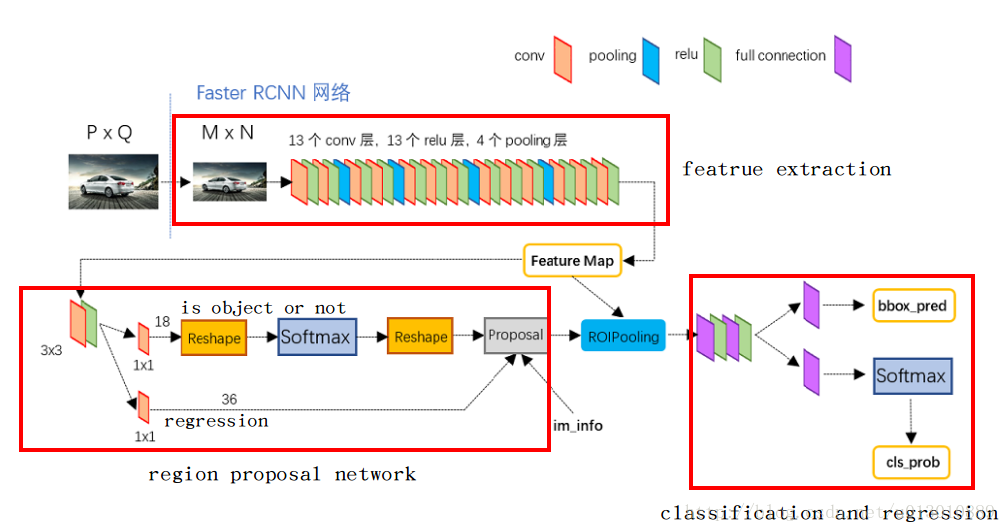

#### 1. 特征提取层 
本层应该关注的是输出层的大小，本层使用了 13 层卷积，13层激活层，4层池化层。
* 卷积层使用了kernel_size=3,pad=1,stride=1 （卷积公式= $ output_ {size} = { input_{size} - kernel_{size} + 2 pad \over stride } + 1$ 带入参数 输入和输出不变）不会改变大小。
* 激活层也不会改变大小。
* 只有池化层会改变大小 kernel_size=2,stride=2 进一次池化层会是原来的 1/2，所以经过4层池化层会变成原来的 1/16

#### 2.RPN(Region Proposal Networks)
特征进入RPN后，经过一次3 3 卷积，特征图大小没有变化，数量还是512（因为有512个过滤器），这个卷积的目的是进一步集中特征信息，紧接着有两个全卷积，即kernel_size=1 1,p=0,stride=1
* rpn_cls 结果是： 60*40*512-d ⊕  1*1*512*18 -> 60*40*9*2  对 9个anchor做2分类
* rpn_bbox 结果是：60*40*512-d ⊕  1*1*512*36==>60*40*9*4   对9个anchor的四个坐标信息（偏移信息）

##### 2.1 anchor的生成规则
特征图的每一个点对应的感受野的大小是16x16大小的区域，参数ratios=[0.5, 1, 2]scales=[8, 16, 32]  通过 这两组组合会产生9个anchor
* 首先看 ratios=[0.5, 1, 2] ，面积不变，长宽比分别是0.5,1,2 会产生算中组合
* 再看scales=[8, 16, 32] ， 长宽分别是 (16*8=128)、(16*16=256)、(16*32=512) 对应三种anchor
* 上面两种两两组合一共会产生9中组合
* 特征图大小为60*40，所以会一共生成60*40*9=21600个Anchor box
* 通过width:(0~60)*16,height(0~40)*16建立shift偏移量数组，再和base_ancho基准坐标数组累加，得到特征图上所有像素对应的Anchors的坐标值，是一个[216000,4]的数组

##### 2.2 proposal 的生成




#### 3.RoiPooling 层
RoiPooling 层的主要作用是：对输入特征图中不同大小的ROI利用池化方法获得固定大小的输出特征图。这层是如何操作的？ 首先将ROI均分成等大的子区域，其数量与输出数量相同,计算每个区域的的最大值或者均值，将每个子区域中的计算结果作为该层输出中的一个元素。
![](roi_pooling-1.gif)

#### 4.全连接分类回归层
用于对每个roi分类 和进一步调整bounding box的位置

### 参考

[本文总结参考](https://www.cnblogs.com/wangyong/p/8513563.html)

[代码参考](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)